In [102]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import itertools as it
import networkx as nx

from sklearn.metrics import normalized_mutual_info_score, r2_score
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress

%matplotlib inline

In [2]:
def plot_matrix(mat):
    
    # Generate a mask for the upper triangle
    mask = np.zeros_like(mat, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(mat, mask=mask, cmap=cmap,
                square=True, xticklabels=5, yticklabels=5,
                linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

In [113]:
df = pd.read_csv('./train.csv')

#### NaN value

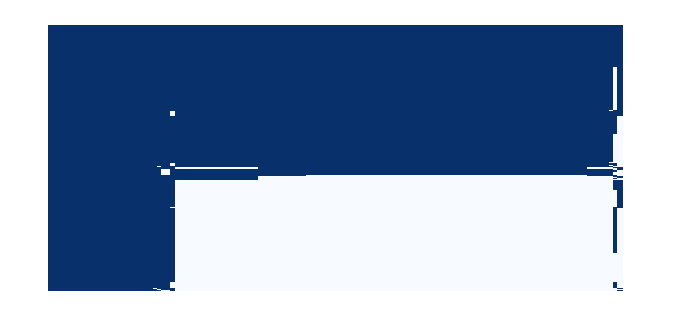

In [121]:
df_nan = df.drop(['target','ID'], 1).notnull().astype(int)
df_nan['sort'] = df_nan.astype(str).apply(lambda x: ''.join(x), axis=1)
df_nan.sort_values(by='sort', inplace=True)
df_nan.drop('sort', 1, inplace=True)

order_columns = df_nan.sum().reset_index().sort_values(by=0, ascending=False)['index'].values
df_nan = df_nan[order_columns]

f, ax = plt.subplots(figsize=(11, 5))
plt.pcolor(df_nan.values, cmap=matplotlib.cm.Blues)
plt.axis('off')
plt.savefig("nan.png", dpi=300)
plt.show()

#### Processing

In [ ]:
categoric_columns = df.select_dtypes(['O']).columns
numeric_columns = df.select_dtypes(['float']).columns

for col in categoric_columns:
    df[col], _ = pd.factorize(df[col])
    
for name in numeric_columns:
    df.loc[df[name].round(5) == 0, name] = 0

#### Correlation Matrix

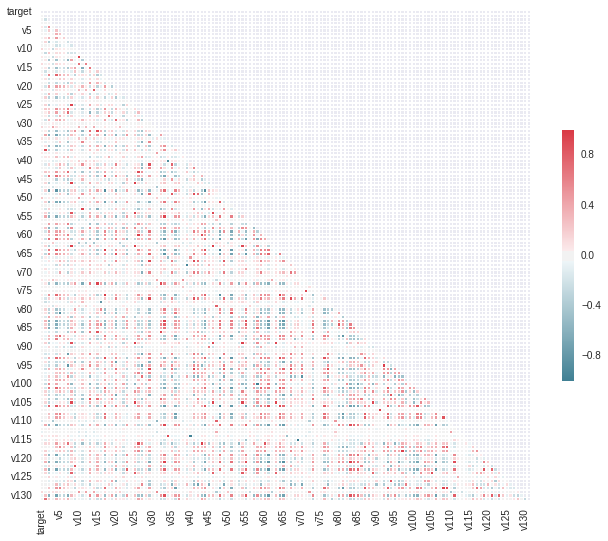

In [5]:
corr = df.drop(['ID'], 1).select_dtypes(['float','int']).corr()
plot_matrix(corr)

#### cluster features based on correlation

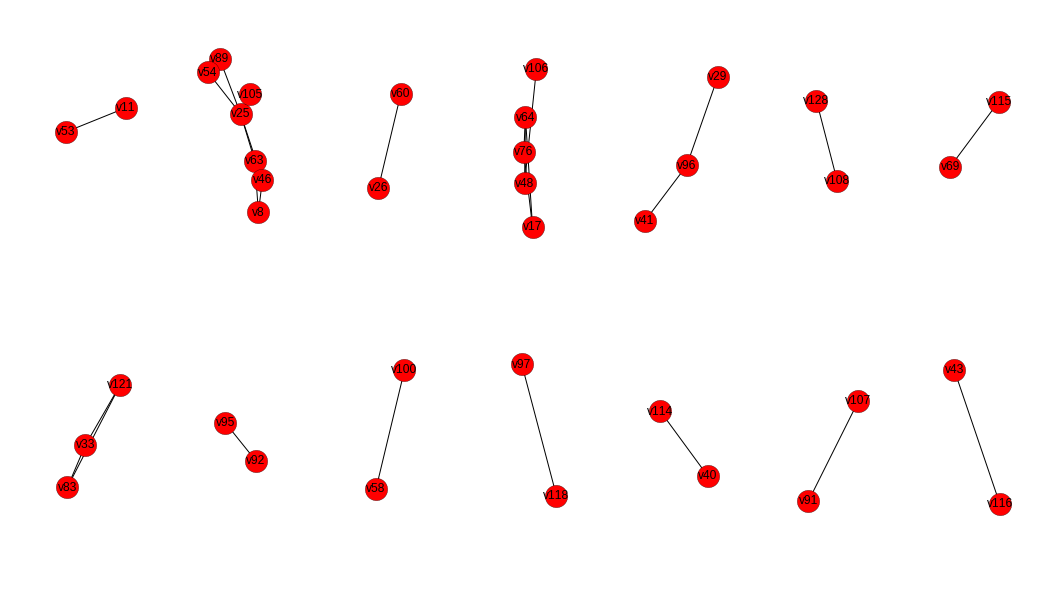

In [6]:
corr_list = corr[(corr ** 2 >= 0.9)].unstack().dropna().reset_index().drop(0, axis=1).values
correlation_graph = nx.Graph(corr_list.tolist())

for subgraph in list(nx.connected_component_subgraphs(correlation_graph)):
    list_node = list(subgraph)
    if len(list_node) == 1:
        correlation_graph.remove_node(list_node[0])

pos = nx.spring_layout(correlation_graph)

subgraphs = list(nx.connected_component_subgraphs(correlation_graph))

plt_cols = 2
plt_rows = len(subgraphs) // plt_cols

fig = plt.figure(figsize=(18, 10))

for i, graph in enumerate(subgraphs):
    fig.add_subplot(plt_cols, plt_rows, i+1)
    nx.draw(graph, pos, node_size=500, with_labels=True)

plt.show()

#### Mutual information Matrix

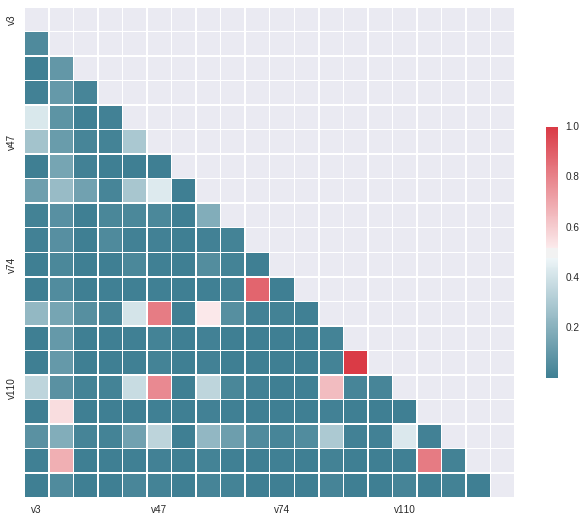

In [7]:
df_cat = df[np.append(categoric_columns, 'target')]
size = df_cat.columns.size

results = np.zeros((size, size))
for i, col1 in enumerate(df_cat.columns):
    for j, col2 in enumerate(df_cat.columns):
           results[j,i] = normalized_mutual_info_score(df_cat[col1], df_cat[col2])
results = pd.DataFrame(results, index=df_cat.columns, columns=df_cat.columns)
plot_matrix(results)

#### Contigency table

In [8]:
# study of v91 and v107

table = pd.DataFrame()
table['v91'] = df['v91']
table['v107'] = df['v107']
table['ones'] = 1

pd.pivot_table(table, values=['ones'], index=['v91'], columns=['v107'], aggfunc=np.sum).reset_index(drop=True).fillna(0).astype(int)

ones                                              
v107   -1      0      1      2      3      4     5    6
0       3      0      0      0      0      0     0    0
1       0  27079      0      0      0      0     0    0
2       0      0  22683      0      0      0     0    0
3       0      0      0  24545      0      0     0    0
4       0      0      0      0  23157      0     0    0
5       0      0      0      0      0  13418     0    0
6       0      0      0      0      0      0  3206    0
7       0      0      0      0      0      0     0  230

#### Linear combinations of features

In [88]:
for col1 , col2 in it.combinations(numeric_columns, 2):
    m = LinearRegression()
    x = df[[col1]].fillna(-1).values
    y = df[[col2]].fillna(-1).values
    m.fit(x, y)
    r2 = r2_score(m.predict(x), y)
    if r2 >= 0.99:
        print('{:4} {:4} :\t{:.2f}\t{: .2f}\t{: .2f}'.format(col1, col2, *m.coef_[0], m.intercept_[0], r2))

v11  v20  :	1.14	 0.17	 0.99
v11  v53  :	1.02	 0.02	 1.00
v17  v76  :	0.71	-0.30	 1.00
v20  v65  :	0.90	-0.15	 0.99
v26  v60  :	0.94	-0.06	 1.00
v29  v41  :	0.88	-0.08	 0.99
v29  v67  :	1.10	 0.17	 0.99
v29  v77  :	0.90	-0.10	 0.99
v29  v96  :	0.81	-0.19	 1.00
v41  v49  :	1.09	 0.14	 0.99
v41  v67  :	1.25	 0.28	 1.00
v41  v96  :	0.92	-0.11	 0.99
v43  v116 :	1.02	 0.02	 1.00
v49  v67  :	1.14	 0.15	 0.99
v92  v95  :	1.05	 0.05	 1.00
v97  v118 :	1.08	 0.12	 0.99


In [89]:
stop = 0
for col1, col2, col3 in it.combinations(numeric_columns, 3):
    if stop == 10:
        break
    m = LinearRegression()
    x = df[[col1, col2]].fillna(-1).values
    y = df[[col3]].fillna(-1).values
    m.fit(x, y)
    r2 = r2_score(m.predict(x), y)
    if r2 >= 0.99:
        stop += 1
        print('{:4} {:4} {:4} :\t{: .2f},{: .2f}\t{: .2f}\t{: .2f}'.format(col1, col2, col3, *m.coef_[0], m.intercept_[0], r2))

v1   v11  v20  :	 0.08, 1.13	 0.23	 0.99
v1   v11  v53  :	 0.08, 1.00	 0.08	 1.00
v1   v17  v76  :	 0.00, 0.71	-0.30	 1.00
v1   v20  v65  :	-0.39, 0.96	-0.48	 0.99
v1   v26  v60  :	-0.10, 1.03	-0.06	 1.00
v1   v29  v41  :	 0.13, 0.85	 0.00	 0.99
v1   v29  v67  :	 0.27, 1.03	 0.34	 1.00
v1   v29  v77  :	 0.02, 0.90	-0.09	 0.99
v1   v29  v96  :	-0.04, 0.82	-0.22	 1.00
v1   v41  v49  :	 0.13, 1.05	 0.22	 0.99


#### Study period of features

In [60]:
col = 'v50'

mapper = df[col].round(3).mul(1000).value_counts()

drop_dup = df[col].duplicated()
s = df[~drop_dup][col].dropna().sort_values().diff().dropna()
s = s.value_counts().reset_index()['index']

time = pd.DataFrame()
time['timeline'] = np.arange(0, df[col].round(3).mul(1000).max(), 1)
time['count'] = time['timeline'].map(mapper)

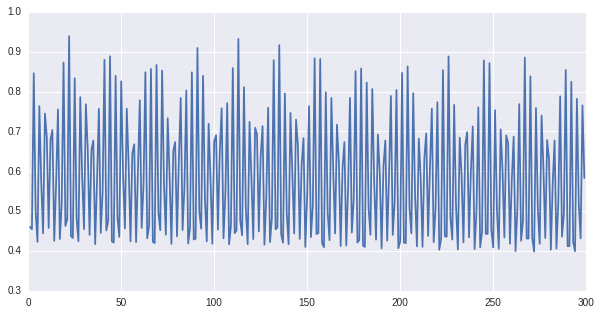

In [87]:
import warnings
warnings.filterwarnings('ignore')

period = 1
max_lag = 300
corr_range = range(1, max_lag, period)
auto_corr_1 = np.array([time['count'].fillna(0).autocorr(lag=x) for x in corr_range])
fig = plt.figure(figsize=(10, 5))
plt.plot(corr_range, auto_corr_1)
plt.show()

In [90]:
for name in numeric_columns:
    df.loc[df[name].round(5) == 0, name] = 0

col = 'v50'

drop_dup = df[col].round(5).duplicated()
s = df[~drop_dup][col].dropna().sort_values().diff().dropna()
s[s.round(5) == 0] = 0
coef = s.value_counts().index[1]
df[[col]].div(coef).round(2).head(10)

,v50
0,613.0
1,940.0
2,412.0
3,2269.0
4,930.0
5,1127.0
6,91.0
7,1828.0
8,1142.0
9,677.0
